In [1115]:
import numpy as np
import pandas as pd
import sqlite3
import json
from datetime import datetime, timedelta, date
from collections import namedtuple
from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from typing import List, Tuple, Dict
from sklearn.compose import ColumnTransformer
import warnings
from xgboost import XGBRegressor

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

In [1116]:
DB_PATH = '/Users/ezras/projects/personal/finance_ml/data/quarterly_financial_data.db'
INFO_CSV_PATH = '/Users/ezras/projects/personal/finance_ml/data/stock_general_info.csv'
TABLE_NAME = 'yahoo_financial_data'
STOCKPUP_TABLE_NAME = 'stockpup_data'


DELTA_PREFIX = 'Delta_'
VS_MKT_IDX = '_vs_'
AVG_REC_SCORE_PREFIX = 'AvgRecScore_'

MISSING_SECTOR = 'MissingSector'
MISSING_INDUSTRY = 'MissingIndustry'

MONTH_TO_QUARTER = {
    1: 4,
    2: 1,
    3: 1,
    4: 1,
    5: 2,
    6: 2,
    7: 2,
    8: 3,
    9: 3,
    10: 3,
    11: 4,
    12: 4
}
    

class StockPupColumns:
    """
    Our dataset comes from over 20 years of 10-Q and 10-K filings made by public companies
     with the U.S. Securities and Exchange Commission. We extract data from both text and
     XBRL filings, fix reporting mistakes, and normalize the data into quarterly time series
     of final restated values.
    """
    # Date Quarter Ends
    QUARTER_END = 'QuarterEnd'
    # The total number of common shares outstanding at the end of a given quarter, including all
    # classes of common stock.
    SHARES = 'Shares'
    # The number of shares the company had at the end of a given quarter, adjusted for splits to
    # be comparable to today's shares.
    SHARES_SPLIT_ADJUSTED = 'SharesSplitAdjusted'
    # If an investor started with 1 share of stock at the end of a given quarter, the split factor
    # for that quarter indicates how many shares the investor would own today as a result of
    # subsequent stock splits.
    SPLIT_FACTOR = 'SplitFactor'
    # Total assets at the end of a quarter.
    ASSETS = 'Assets'
    # Current assets at the end of a quarter.
    CURRENT_ASSETS = 'CurrentAssets'
    # Total liabilities at the end of a quarter.
    LIABILITIES = 'Liabilities'
    # Current liabilities at the end of a quarter.
    CURRENT_LIABILITIES = 'CurrentLiabilities'
    # Total shareholders' equity at the end of a quarter, including both common and preferred
    # stockholders.
    SHAREHOLDER_EQUITY = 'ShareholdersEquity'
    # Non-controlling or minority interest, if any, excluded from Shareholders equity.
    NON_CONTROLLING_INTEREST = 'NonControllingInterest'
    # Preferred equity, if any, included in Shareholders equity.
    PREFERRED_EQUITY = 'PreferredEquity'
    # Total Goodwill and all other Intangible assets, if any.
    GOODWILL_AND_INTANGIBLES = 'GoodwillIntangibles'
    # All long-term debt including capital lease obligations.
    LONG_TERM_DEBT = 'LongTermDebt'
    # Total revenue for a given quarter.
    REVENUE = 'Revenue'
    # Earnings or Net Income for a given quarter.
    EARNINGS = 'Earnings'
    # Earnings available for common stockholders - Net income minus earnings that must be
    # distributed to preferred shareholders. May be omitted when not reported by the company.
    EARNINGS_AVAILABLE_FOR_COMMON_STOCKHOLDERS = 'EarningsAvailableForCommonStockholders'
    # Basic earnings per share for a given quarter.
    EPS_BASIC = 'EPS_basic'
    # Diluted earnings per share.
    EPS_DILUTED = 'EPS_diluted'
    # Common stock dividends paid during a quarter per share, including all regular and special
    # dividends and distributions to common shareholders.
    DIVIDEND_PER_SHARE = 'DividendPerShare'
    # Cash produced by operating activities during a given quarter, including Continuing and
    # Discontinued operations.
    CASH_FROM_OPERATING_ACTIVITES = 'CashFromOperatingActivities'
    # Cash produced by investing activities during a given quarter, including Continuing and
    # Discontinued operations.
    CASH_FROM_INVESTING_ACTIVITIES = 'CashFromInvestingActivities'
    # Cash produced by financing activities during a given quarter, including Continuing and
    # Discontinued operations.
    CASH_FROM_FINANCING_ACTIVITES = 'CashFromFinancingActivities'
    # Change in cash and cash equivalents during a given quarter, including Effect of Exchange
    # Rate Movements and Other Cash Change Adjustments, if any.
    CASH_CHANGE_DURING_PERIOD = 'CashChangeDuringPeriod'
    # Cash and cash equivalents at the end of a quarter, including Continuing and
    # Discontinued operations.
    CASH_AT_END_OF_PERIOD = 'CashAtEndOfPeriod'
    # Capital Expenditures are the cash outflows for long-term productive assets, net of cash
    # from disposals of capital assets.
    CAPITAL_EXPENDITURES = 'CapitalExpenditures'
    # The medium price per share of the company common stock during a given quarter. The prices
    # are as reported, and are not adjusted for subsequent dividends.
    PRICE = 'Price'  # Average price during quarter
    # The highest price per share of the company common stock during a given quarter.
    PRICE_HIGH = 'PriceHigh'
    # The lowest price of the company common stock during a quarter.
    PRICE_LOW = 'PriceLow'
    # Return on equity is the ratio of Earnings (available to common stockholders)
    # TTM (over the Trailing Twelve Months) to TTM average common shareholders' equity.
    ROE = 'ROE'
    # Return on assets is the ratio of total Earnings TTM to TTM average Assets.
    ROA = 'ROA'
    # Common stockholders' equity per share, also known as BVPS.
    BOOK_VALUE_OF_EQUITY_PER_SHARE = 'BookValueOfEquityPerShare'
    # The ratio of Price to Book value of equity per share as of the previous quarter.
    P_B_RATIO = 'P_B_ratio'
    # The ratio of Price to EPS diluted TTM as of the previous quarter.
    P_E_RATIO = 'P_E_ratio'
    # The aggregate amount of dividends paid per split-adjusted share of common stock from the
    # first available reporting quarter until a given quarter.
    CUM_DIVIDENDS_PER_SHARE = 'CumulativeDividendsPerShare'
    # The ratio of Dividends TTM to Earnings (available to common stockholders) TTM.
    DIVIDEND_PAYOUT_RATIO = 'DividendPayoutRatio'
    # The ratio of Long-term debt to common shareholders' equity (Shareholders equity minus
    # Preferred equity).
    LONG_TERM_DEBT_TO_EQUITY_RATIO = 'LongTermDebtToEquityRatio'
    # The ratio of common shareholders' equity (Shareholders equity minus Preferred equity) to
    # Assets.
    EQUITY_TO_ASSETS_RATIO = 'EquityToAssetsRatio'
    # The ratio of Earnings (available for common stockholders) TTM to Revenue TTM.
    NET_MARGIN = 'NetMargin'
    # The ratio of Revenue TTM to TTM average Assets.
    ASSET_TURNOVER = 'AssetTurnover'
    # Cash from operating activities minus the Capital Expenditures for a quarter.
    FREE_CASH_FLOW_PER_SHARE = 'FreeCashFlowPerShare'
    # The ratio of Current assets to Current liabilities.
    CURRENT_RATIO = 'CurrentRatio'
    
    @staticmethod
    def columns():
        return [getattr(StockPupColumns, col) for col in dir(StockPupColumns) if col[0] != '_' and col != 'columns']

class QuarterlyColumns:
    TICKER_SYMBOL = 'TickerSymbol'
    QUARTER = 'Quarter'
    YEAR = 'Year'
    PRICE_AVG = 'PriceAvg'
    PRICE_HI = 'PriceHigh'
    PRICE_LO = 'PriceLow'
    PRICE_AT_END_OF_QUARTER = 'PriceEoQ'
    AVG_RECOMMENDATIONS = 'AvgRecommendations'
    AVG_RECOMMENDATION_SCORE = 'AvgRecommendationScore'
    SPLIT = 'Split'
    EBIT = 'Ebit'
    PROFIT = 'GrossProfit'
    REVENUE = 'TotalRevenue'
    RND = 'ResearchDevelopment'
    OPERATING_EXPENSES = 'TotalOperatingExpenses'
    INCOME_PRETAX = 'IncomeBeforeTax'
    INCOME_TAX = 'IncomeTaxExpense'
    OPERATING_INCOME = 'OperatingIncome'
    NET_INCOME = 'NetIncome'
    DIVIDENDS = 'DividendsPaid'
    STOCK_REPURCHASED = 'RepurchaseOfStock'
    STOCK_ISSUED = 'IssuanceOfStock'
    DEPRECIATION = 'Depreciation'
    NET_BORROWINGS = 'NetBorrowings'
    INVESTMENTS = 'Investments'
    CASH = 'Cash'
    COMMON_STOCK = 'CommonStock'
    ASSETS = 'TotalAssets'
    LIABILITIES = 'TotalLiab'
    DEBT_LONG = 'LongTermDebt'
    DEBT_SHORT = 'ShortLongTermDebt'
    DATE = 'Date'
    VOLUME = 'Volume'
    EARNINGS = 'Earnings'
    STOCKHOLDER_EQUITY = 'TotalStockholderEquity'
    VOLATILITY = 'Volatility'
    SECTOR = 'Sector'
    INDUSTRY = 'Industry'
    MARKET_CAP = 'MarketCap'
    AGE_OF_DATA = 'AgeOfData'
    WORKING_CAPITAL_RATIO = 'AssetsToLiabilitiesRatio'
    AVG_PE_RATIO = 'AvgPriceToEarningsRatio'
    DEBT_EQUITY_RATIO = 'DebtToEquityRatio'
    ROE = 'ReturnOnEquity'
    PRICE_BOOK_RATIO = 'PriceToBookRatio'
    FCF = 'FreeCashFlow'
    PROFIT_MARGIN = 'ProfitMargin'
    
    @staticmethod
    def columns():
        return [getattr(QuarterlyColumns, col) for col in dir(QuarterlyColumns) if col[0] != '_' and col != 'columns']

INDEX_COLUMNS = [QuarterlyColumns.TICKER_SYMBOL, 
                 QuarterlyColumns.QUARTER, 
                 QuarterlyColumns.YEAR]
    
QuarterlyIndex = namedtuple('QuarterlyIndex', INDEX_COLUMNS)
TICKER_SYMBOL, QUARTER, YEAR = 0, 1, 2

PRICE_ONLY_DELTA_COLUMNS = [
    QuarterlyColumns.PRICE_AVG,
    QuarterlyColumns.VOLATILITY
]

DELTA_COLUMNS = [
    QuarterlyColumns.PRICE_AVG,
    QuarterlyColumns.CASH,
    QuarterlyColumns.EARNINGS,
    QuarterlyColumns.AVG_PE_RATIO,
    QuarterlyColumns.DEBT_EQUITY_RATIO,
    QuarterlyColumns.ROE,
    QuarterlyColumns.WORKING_CAPITAL_RATIO,
    QuarterlyColumns.PRICE_BOOK_RATIO,
    QuarterlyColumns.PROFIT_MARGIN,
    QuarterlyColumns.OPERATING_INCOME
]

CATEGORICAL_COLUMNS = [
    QuarterlyColumns.QUARTER,
    QuarterlyColumns.SECTOR,
#     QuarterlyColumns.INDUSTRY
]

VS_MARKET_INDICES_COLUMNS = [
    f'{DELTA_PREFIX}{QuarterlyColumns.PRICE_AVG}',
    QuarterlyColumns.VOLATILITY,
]

MARKET_INDICES = ['^DJI']  #, 'VTSAX', '^IXIC', '^GSPC', '^RUT', '^NYA']


FORMULAE = {
    QuarterlyColumns.VOLATILITY: lambda row: (
        row[QuarterlyColumns.PRICE_HI] - row[QuarterlyColumns.PRICE_LO]) / row[QuarterlyColumns.PRICE_AVG],

    QuarterlyColumns.WORKING_CAPITAL_RATIO: lambda row: (
        row[QuarterlyColumns.ASSETS] / row[QuarterlyColumns.LIABILITIES]),

    QuarterlyColumns.AGE_OF_DATA: lambda row: (
        datetime.now().date() - datetime.strptime(row[QuarterlyColumns.DATE], '%Y-%m-%d').date()).days/90,

    QuarterlyColumns.AVG_PE_RATIO: lambda row: (
        row[QuarterlyColumns.PRICE_AVG] / row[QuarterlyColumns.EARNINGS]),

    QuarterlyColumns.DEBT_EQUITY_RATIO: lambda row: (
        row[QuarterlyColumns.DEBT_LONG] + row[QuarterlyColumns.DEBT_SHORT]) / row[QuarterlyColumns.STOCKHOLDER_EQUITY],

    QuarterlyColumns.ROE: lambda row: (
        row[QuarterlyColumns.EARNINGS] - row[QuarterlyColumns.DIVIDENDS]) / row[QuarterlyColumns.STOCKHOLDER_EQUITY],

    QuarterlyColumns.PRICE_BOOK_RATIO: lambda row: (
        row[QuarterlyColumns.ASSETS] - row[QuarterlyColumns.LIABILITIES]) / row[QuarterlyColumns.MARKET_CAP],

    QuarterlyColumns.PROFIT_MARGIN: lambda row: (
        row[QuarterlyColumns.NET_INCOME] / row[QuarterlyColumns.REVENUE])
}

TARGET_COL_BASIS = f'{DELTA_PREFIX}{QuarterlyColumns.PRICE_AVG}'
TARGET_COLUMN = f'NextQuarter_{TARGET_COL_BASIS}'

FEATURE_COLUMNS = [
    QuarterlyColumns.AGE_OF_DATA,
    QuarterlyColumns.VOLATILITY,
    QuarterlyColumns.AVG_RECOMMENDATION_SCORE,
    QuarterlyColumns.AVG_PE_RATIO,
    QuarterlyColumns.DEBT_EQUITY_RATIO,
    QuarterlyColumns.ROE,
    QuarterlyColumns.WORKING_CAPITAL_RATIO,
    QuarterlyColumns.PRICE_BOOK_RATIO,
    QuarterlyColumns.PROFIT_MARGIN
] + [
    f'{DELTA_PREFIX}{col}' for col in DELTA_COLUMNS
] + [
    f'{col}{VS_MKT_IDX}{mkt_idx}' for mkt_idx in MARKET_INDICES for col in VS_MARKET_INDICES_COLUMNS
]

In [1117]:
db_conn = sqlite3.connect(DB_PATH)

quarterly_df = pd.read_sql_query(f'SELECT * FROM {TABLE_NAME}', db_conn)
db_conn.close()

# This needs to be above the filters below otherwise we'll drop quarterly data! (indices have no revenue)
market_index_df = quarterly_df[quarterly_df[QuarterlyColumns.TICKER_SYMBOL].isin(MARKET_INDICES)]

market_index_df.dropna(subset=[QuarterlyColumns.DATE,
                               QuarterlyColumns.PRICE_AVG,
                               QuarterlyColumns.PRICE_HI,
                               QuarterlyColumns.PRICE_LO,
                               ],
                       inplace=True)

quarterly_df.dropna(subset=[QuarterlyColumns.DATE,
                            QuarterlyColumns.REVENUE,
                            QuarterlyColumns.PRICE_AVG,
                            QuarterlyColumns.PRICE_HI,
                            QuarterlyColumns.PRICE_LO,
                            QuarterlyColumns.EARNINGS,
                            QuarterlyColumns.MARKET_CAP],
                    inplace=True)
quarterly_df = quarterly_df[((quarterly_df[QuarterlyColumns.REVENUE] != 0) &
                             (quarterly_df[QuarterlyColumns.EARNINGS] != 0) &
                             (quarterly_df[QuarterlyColumns.MARKET_CAP] != 0) &
                             (~quarterly_df[QuarterlyColumns.TICKER_SYMBOL].isin(MARKET_INDICES)))]

quarterly_df.set_index([QuarterlyColumns.TICKER_SYMBOL,
                        QuarterlyColumns.QUARTER,
                        QuarterlyColumns.YEAR],
                       inplace=True)
quarterly_df.sort_index(inplace=True)

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1118]:
db_conn = sqlite3.connect(DB_PATH)

stockpup_df = pd.read_sql_query(f'SELECT * FROM {STOCKPUP_TABLE_NAME}', db_conn)
db_conn.close()


def _date_to_index(dt: datetime.date):
    # shift date into the next month if it's at the end of a month
    new_date = dt + timedelta(days=15) if dt.day > 20 else dt

    q = MONTH_TO_QUARTER[new_date.month]

    year = new_date.year - 1 if new_date.month == 1 else new_date.year
    return QuarterlyIndex('', q, year)


def process_stockpup_df(df):
    df.dropna(subset=[StockPupColumns.SHARES, 
                      StockPupColumns.SHARES_SPLIT_ADJUSTED,
                      StockPupColumns.FREE_CASH_FLOW_PER_SHARE,
                      StockPupColumns.EARNINGS,
                      StockPupColumns.SHAREHOLDER_EQUITY,
                      StockPupColumns.LIABILITIES,
                      StockPupColumns.PRICE],
              inplace=True)
    df = df[((df[StockPupColumns.REVENUE] != 0) &
             (df[StockPupColumns.EARNINGS] != 0))]
    
    df[StockPupColumns.QUARTER_END] = pd.to_datetime(df[StockPupColumns.QUARTER_END])

    df[QuarterlyColumns.QUARTER] = df[StockPupColumns.QUARTER_END].apply(
        lambda r: _date_to_index(r)[QUARTER])
    df[QuarterlyColumns.YEAR] = df[StockPupColumns.QUARTER_END].apply(lambda r: _date_to_index(r)[YEAR])
    df[QuarterlyColumns.DIVIDENDS] = df[StockPupColumns.DIVIDEND_PER_SHARE] * df[
        StockPupColumns.SHARES]
    df[QuarterlyColumns.DATE] = df[StockPupColumns.QUARTER_END].apply(lambda r: str(r.date()))
    df[QuarterlyColumns.OPERATING_INCOME] = df[StockPupColumns.FREE_CASH_FLOW_PER_SHARE] * df[
        StockPupColumns.SHARES]
    df[QuarterlyColumns.MARKET_CAP] = df[StockPupColumns.SHARES_SPLIT_ADJUSTED] * df[StockPupColumns.PRICE]
    df[QuarterlyColumns.DEBT_SHORT] = 0  # I think short long term debt is figured into long term debt
#     df[QuarterlyColumns.EBIT] = ???  # TODO: Compute EBIT?

    df.rename(columns={
        StockPupColumns.ASSETS: QuarterlyColumns.ASSETS,
        StockPupColumns.REVENUE: QuarterlyColumns.REVENUE,
        StockPupColumns.LIABILITIES: QuarterlyColumns.LIABILITIES,
        StockPupColumns.LONG_TERM_DEBT: QuarterlyColumns.DEBT_LONG,
        StockPupColumns.SHAREHOLDER_EQUITY: QuarterlyColumns.STOCKHOLDER_EQUITY,
        StockPupColumns.CASH_AT_END_OF_PERIOD: QuarterlyColumns.CASH,
        StockPupColumns.PRICE: QuarterlyColumns.PRICE_AVG,
        StockPupColumns.PRICE_LOW: QuarterlyColumns.PRICE_LO,
        StockPupColumns.PRICE_HIGH: QuarterlyColumns.PRICE_HI,
        StockPupColumns.SPLIT_FACTOR: QuarterlyColumns.SPLIT,
        StockPupColumns.SHARES_SPLIT_ADJUSTED: QuarterlyColumns.COMMON_STOCK,
        StockPupColumns.EARNINGS: QuarterlyColumns.EARNINGS  # These aren't exactly the same
    }, inplace=True)
    
    df[QuarterlyColumns.DEBT_LONG] = df[QuarterlyColumns.DEBT_LONG].apply(lambda row: int(row))
    df[QuarterlyColumns.NET_INCOME] = df[QuarterlyColumns.EARNINGS]  # These aren't exactly the same...

    # Filter only to columns in QuarterlyColumns
    df = df[[col for col in df.columns if col in QuarterlyColumns.columns()]]
    
    df.set_index([QuarterlyColumns.TICKER_SYMBOL,
                  QuarterlyColumns.QUARTER,
                  QuarterlyColumns.YEAR],
                 inplace=True)
    df.sort_index(inplace=True)
    
    # Filter out all data in stockpup_df that exists in quarterly_df (by index)
    df = df[~df.index.isin(quarterly_df.index)]
    
    # Drop duplicates (occurs if quarter end dates are close to eachother)
    df = df.loc[~df.index.duplicated(keep='last')]
    
    return df

stockpup_df = process_stockpup_df(stockpup_df)

quarterly_df = pd.concat([quarterly_df, stockpup_df])
quarterly_df.sort_index(inplace=True)

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [1119]:
stock_info_df = pd.read_csv(INFO_CSV_PATH)[['tickerSymbol', 'sector', 'industry']]
stock_info_df.rename(columns={
    'tickerSymbol': QuarterlyColumns.TICKER_SYMBOL,
    'sector': QuarterlyColumns.SECTOR,
    'industry': QuarterlyColumns.INDUSTRY
}, inplace=True)
stock_info_df.set_index([QuarterlyColumns.TICKER_SYMBOL], inplace=True)

quarterly_df = quarterly_df.join(stock_info_df, on=[QuarterlyColumns.TICKER_SYMBOL])

quarterly_df[QuarterlyColumns.SECTOR].fillna(MISSING_SECTOR, inplace=True)
quarterly_df[QuarterlyColumns.INDUSTRY].fillna(MISSING_INDUSTRY, inplace=True)
quarterly_df[QuarterlyColumns.DEBT_SHORT].fillna(0, inplace=True)

In [1120]:
for col_name, fn in FORMULAE.items():
        quarterly_df[col_name] = quarterly_df.apply(fn, axis=1)

market_index_df[QuarterlyColumns.VOLATILITY] = market_index_df.apply(FORMULAE[QuarterlyColumns.VOLATILITY], axis=1)
market_index_df.set_index([QuarterlyColumns.TICKER_SYMBOL,
                           QuarterlyColumns.QUARTER,
                           QuarterlyColumns.YEAR],
                          inplace=True)
market_index_df.sort_index(inplace=True)

In [1121]:
def get_prev_quarterly_index(index: QuarterlyIndex):
    if index[QUARTER] == 1:
        return QuarterlyIndex(index[TICKER_SYMBOL], 4, index[YEAR] - 1)

    return QuarterlyIndex(index[TICKER_SYMBOL], index[QUARTER] - 1, index[YEAR])


def add_delta_columns(row: pd.Series, df: pd.DataFrame, columns: list):    
    try:
        prev_quarter_row = df.loc[get_prev_quarterly_index(row.name)]  # row.name returns the multiIndex tuple
    except:
#         print(f'Unable to find prev quarter info for {row.name}')
        prev_quarter_row = pd.DataFrame()
    
    if not prev_quarter_row.empty:
        new_cols = []

        for col in columns:
            if prev_quarter_row[col] == 0:
                new_cols.append(0)
            else:
                # converting to float to get rid of index terms
                new_cols.append(float((row[col] - prev_quarter_row[col]) / prev_quarter_row[col]))

        return pd.Series(new_cols)

    return pd.Series([None]*len(columns))


delta_col_names = [f'{DELTA_PREFIX}{col}' for col in DELTA_COLUMNS]
quarterly_df[delta_col_names] = quarterly_df.apply(add_delta_columns, axis=1, df=quarterly_df, columns=DELTA_COLUMNS)
# quarterly_df.dropna(subset=delta_col_names, inplace=True)

delta_col_mkt_index_names = [f'{DELTA_PREFIX}{col}' for col in PRICE_ONLY_DELTA_COLUMNS]
market_index_df[delta_col_mkt_index_names] = market_index_df.apply(add_delta_columns, axis=1, df=market_index_df, columns=PRICE_ONLY_DELTA_COLUMNS)
market_index_df.dropna(subset=delta_col_mkt_index_names, inplace=True)


In [1122]:
def compare_to_market_index(row: pd.Series, market_indices=None):
    market_indices = MARKET_INDICES if not market_indices else market_indices
    
    new_cols = []
    for col in VS_MARKET_INDICES_COLUMNS:
        for mkt_idx in market_indices:
            try:
                mkt_idx_row = market_index_df.loc[mkt_idx, row.name[QUARTER], row.name[YEAR]]
            except:
#                 print(f'Unable to find {mkt_idx} Q{row.name[QUARTER]} {row.name[YEAR]}')
                mkt_idx_row = pd.DataFrame()
            
            if not mkt_idx_row.empty:
                if mkt_idx_row[col] == 0:
                    new_cols.append(0)
                else:
                    # converting to float to drop index terms
                    new_cols.append(float(row[col] / mkt_idx_row[col]))
            else:
                new_cols.append(None)

    return pd.Series(new_cols)

vs_market_indices_col_names = [f'{col}{VS_MKT_IDX}{mkt_idx}' 
                               for col in VS_MARKET_INDICES_COLUMNS for mkt_idx in MARKET_INDICES]
quarterly_df[vs_market_indices_col_names] = quarterly_df.apply(compare_to_market_index, axis=1)
quarterly_df.dropna(subset=vs_market_indices_col_names, inplace=True)

In [1123]:
def get_avg_recommendation_score(row: pd.Series):
    if row[QuarterlyColumns.AVG_RECOMMENDATIONS] is None or str(row[QuarterlyColumns.AVG_RECOMMENDATIONS]) == 'nan':
        return pd.Series([0])
    
    avg_recommendation = np.mean([float(v) for v in json.loads(row[QuarterlyColumns.AVG_RECOMMENDATIONS]).values()])
    return pd.Series([avg_recommendation])


quarterly_df[QuarterlyColumns.AVG_RECOMMENDATION_SCORE] = quarterly_df.apply(get_avg_recommendation_score, axis=1)


In [1124]:
# ---------- Break Recommendations up by firm ---------
#      skipping for now...
# recommendations = [json.loads(contents) if contents else {} 
#                    for contents in quarterly_df[QuarterlyColumns.AVG_RECOMMENDATIONS]]
# recommendations = [
#     {f'{AVG_REC_SCORE_PREFIX}{firm}': value if value is not None else 0 for firm, value in recommendation.items()} 
#     for recommendation in recommendations]
# recommendations_df = pd.DataFrame(recommendations).fillna(0)


# quarterly_df = pd.merge(quarterly_df, recommendations_df, left_index=True, right_index=True)

In [1125]:
def get_next_quarterly_index(index: QuarterlyIndex):
    if index[QUARTER] == 4:
        return QuarterlyIndex(index[TICKER_SYMBOL], 1, index[YEAR] + 1)

    return QuarterlyIndex(index[TICKER_SYMBOL], index[QUARTER] + 1, index[YEAR])

def get_target_col_prediction(row: pd.Series, df: pd.DataFrame):
    try:
        next_quarter_data = df.loc[get_next_quarterly_index(row.name)]
        return next_quarter_data[TARGET_COL_BASIS]
    except: 
        return None

# Add Y (target) to quarterly_df
quarterly_df[TARGET_COLUMN] = quarterly_df.apply(get_target_col_prediction, axis=1, df=quarterly_df)

In [1126]:
# Get dataframe of rows to make predictions on (most recent rows)
prediction_candidate_df = quarterly_df[quarterly_df[TARGET_COLUMN].isnull()]

In [1127]:
def split_feature_target(df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Split processed data into features and target.

    :param df: processed data for model training.
    :param target_col: target column name.
    :return: X: features for model training.
             y: targets for model training.
    """
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    return X, y

In [1128]:
class OutlierExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns, num_std_threshold=3):
        self.columns = columns
        self.threshold = num_std_threshold
    def fit(self, X):
        return self
    def transform(self, X):
        X_new = X[(np.abs(stats.zscore(X[self.columns])) < self.threshold).all(axis=1)]
        print(f'OutlierExtractor removed {X.shape[0] - X_new.shape[0]} rows')
        return X_new

class ColumnFilter(BaseEstimator, TransformerMixin):
    def __init__(self, columns, dropna=True):
        self.columns = columns
        self.dropna = dropna
    def fit(self, X):
        return self
    def transform(self, X):
        X_new = X[self.columns]
        if self.dropna:
            X_new.dropna(inplace=True)
        return X_new

class CategoricalToDummy(BaseEstimator, TransformerMixin):

    def __init__(self, categorical_columns, drop_one=True, drop_original=True):
        """
        Transforms categorical columns to one-hot-encoded columns named as such:
            '<original column name>_<category name>'

        Args
            categorical_columns: List[str] of categorical columns in X
            drop_one: (bool) when converting to categorical columns, whether to drop the first category name.
                Eg. if a column has categories ['A', 'B'], drop category 'A'. (since 'B' == 1 or 0 is sufficient)
            drop_original: (bool) when transforming categorical columns in X, whether to drop the original columns
        """
        self.categorical_columns = categorical_columns
        self.drop_one = drop_one
        self.drop_original = drop_original

    def fit(self, X, y=None):
        X_temp = X.copy()
        self.dummy_values = {}
        self.base_category_by_col = {}

        for col in self.categorical_columns:
            self.dummy_values[col] = X_temp[col].unique()
            if self.drop_one:
                base_temp = [x for x in self.dummy_values[col] if str(x) != 'nan']
                self.base_category_by_col[col] = base_temp[0]

        return self

    def transform(self, X, y=None):
        X_temp = X.copy()

        for col in self.categorical_columns:
            for cat in self.dummy_values[col]:
                if str(cat) == 'nan':
                    X_temp[str(col) + '_' + str(cat)] = X_temp[col].isnull().astype(int)
                else:
                    X_temp[str(col) + '_' + str(cat)] = (X_temp[col] == cat).astype(int)
            if self.drop_one:
                X_temp.drop(labels=[str(col) + '_' + str(self.base_category_by_col[col])], axis=1, inplace=True)

        if self.drop_original:
            X_temp.drop(labels=self.categorical_columns, axis=1, inplace=True)

        return X_temp

class NumericalScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns: List, **kwargs):
        self.columns = columns
        self.kwargs = kwargs
    def fit(self, X):
        self.column_transformer = ColumnTransformer(transformers=[
            ('scaler', StandardScaler(), self.columns)
        ])
        self.column_transformer.fit_transform(X[self.columns])
        return self
    def transform(self, X):
        X_temp = X.copy()
        X_temp[self.columns] = self.column_transformer.transform(X)
        return X_temp

class Splitter(BaseEstimator, TransformerMixin):
    def __init__(self, test_size=0.2, target_col=TARGET_COLUMN):
        self.test_size = test_size
        self.target_col = target_col
    def fit(self, X):
        return self
    def transform(self, X):
        n_test = int(len(X) * self.test_size)
        X_test, y_test = split_feature_target(
            X.sample(n=n_test, random_state=7), self.target_col)
        
        X_train, y_train = split_feature_target(
            X.loc[~X.index.isin(X_test.index)], self.target_col)
        
        return X_train, y_train, X_test, y_test

class IndexSwitchTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, index_columns = INDEX_COLUMNS):
        self.index_columns = index_columns
        self.index_df = None

    def fit(self, X):
        if self.index_df is None:
            X_temp = X.reset_index()
            self.index_df = X_temp[self.index_columns]
        return self

    def transform(self, X):
        if all([col in self.index_columns for col in X.index.names]):
            X_new = X.reset_index()
        else:
            X_new = X.join(self.index_df, how='left')
            X_new = X_new.set_index(self.index_columns)
        return X_new

class DateFilter(BaseEstimator, TransformerMixin):
    def __init__(self, start_date: date, date_column: str = QuarterlyColumns.DATE):
        self.start_date = start_date
        self.date_column = date_column
    def fit(self, X):
        return self
    def transform(self, X):
        X_new = X[pd.to_datetime(X[self.date_column]) >= self.start_date]
        print(f'DateFilter removed {X.shape[0] - X_new.shape[0]} rows')
        return X_new

index_transformer = IndexSwitchTransformer(INDEX_COLUMNS)  
numerical_scaler = NumericalScaler(FEATURE_COLUMNS)
categorical_to_dummy = CategoricalToDummy(CATEGORICAL_COLUMNS)
date_filter = DateFilter(start_date=datetime(2000, 1, 1))

data_pipeline = Pipeline(steps=[
    ('reset_index', index_transformer),
    ('filter_dates', date_filter),
    ('filter_columns', ColumnFilter(FEATURE_COLUMNS + CATEGORICAL_COLUMNS + [TARGET_COLUMN])),
    ('extract_outliers', OutlierExtractor(FEATURE_COLUMNS)),
    ('one_hot_encode', categorical_to_dummy),
    ('numeric_scaler', numerical_scaler),
    ('restore_index', index_transformer)
])

quarterly_df
X_transformed = data_pipeline.fit_transform(quarterly_df)
X_transformed
X_train, y_train, X_test, y_test = Splitter().transform(X_transformed)

DateFilter removed 8700 rows
OutlierExtractor removed 4716 rows


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1129]:
reg_model = LinearRegression(fit_intercept=True,
                             normalize=True).fit(X_train, y_train)

for i, col in enumerate(X_train.columns):
    print(f'The coefficient for {col} is {reg_model.coef_[i]}')
print(f'The intercept for our model is {reg_model.intercept_}')

score = reg_model.score(X_test, y_test)
print('*'*50)
print(f'The score of our model is {score}')

y_pred = reg_model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

abs_err = abs(y_pred - y_test) * 100.  # absolute error percentage points (eg. 5= prediction is 5% off)
err = (y_pred - y_test) * 100.

The coefficient for AgeOfData is 0.004973125841951792
The coefficient for Volatility is 0.0045054371485524275
The coefficient for AvgRecommendationScore is -0.0004774359087219219
The coefficient for AvgPriceToEarningsRatio is 0.003013046157513546
The coefficient for DebtToEquityRatio is -0.0034213457691866286
The coefficient for ReturnOnEquity is 0.0030929313013307617
The coefficient for AssetsToLiabilitiesRatio is -0.0009193889111015122
The coefficient for PriceToBookRatio is 0.008780638156057497
The coefficient for ProfitMargin is -0.0006218236387877319
The coefficient for Delta_PriceAvg is 0.0324992284602266
The coefficient for Delta_Cash is 0.001415866309323121
The coefficient for Delta_Earnings is 0.0007225639310205233
The coefficient for Delta_AvgPriceToEarningsRatio is -0.0006569099034395622
The coefficient for Delta_DebtToEquityRatio is -8.401634183263427e-06
The coefficient for Delta_ReturnOnEquity is 0.0017354712407790342
The coefficient for Delta_AssetsToLiabilitiesRatio is 

In [1130]:
booster = 'gbtree'  #'dart'  #'gblinear'
xgb_model = XGBRegressor(seed=100,
                         n_estimators=100,
                         max_depth=3,
                         learning_rate=0.1,
                         min_child_weight=1,
                         subsample=1,
                         colsample_bytree=1,
                         colsample_bylevel=1,
                         gamma=0,
                         booster=booster).fit(X_train, y_train)

if booster == 'gblinear':
    for i, col in enumerate(X_train.columns):
        print(f'The coefficient for {col} is {xgb_model.coef_[i]}')
    print(f'The intercept for our model is {xgb_model.intercept_}')

xgb_score = xgb_model.score(X_test, y_test)
print('*'*50)
print(f'The score of our model is {score}')

y_pred_xgb = xgb_model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_xgb))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_xgb))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)))

abs_err_xgb = abs(y_pred_xgb - y_test) * 100.  # absolute error percentage points (eg. 5= prediction is 5% off)
err_xgb = (y_pred_xgb - y_test) * 100.

**************************************************
The score of our model is 0.06919190401719533
Mean Absolute Error: 0.08168734018972124
Mean Squared Error: 0.01347125658129413
Root Mean Squared Error: 0.11606574249663046


Text(0.5, 0, 'DeltaPriceAvg% Error')

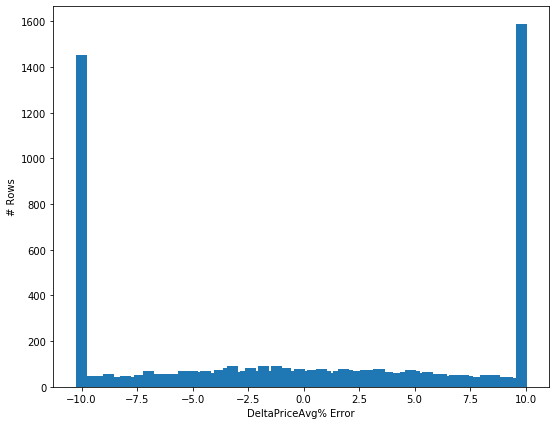

In [1131]:
from collections import Counter

def get_counts_by_bin(items: pd.Series, bins: List):
    items = sorted(items)
    bins = sorted(bins)
    
    assigned = []
    current_bin = 0
    for item in items:
        while(item > bins[current_bin] and current_bin < len(bins) - 1):
            current_bin += 1
        
        assigned.append(current_bin)
    
    return {bins[key]: value for key, value in Counter(assigned).items()}
    
    

bins = [-10 +.2*i for i in range(100)]

counts_by_bin = get_counts_by_bin(err, bins)

fig, ax1 = plt.subplots(figsize=(9, 7))
fig.subplots_adjust(left=0.115, right=0.88)
ax1.bar(counts_by_bin.keys(), height=counts_by_bin.values(), width=0.5)
ax1.set_ylabel('# Rows')
ax1.set_xlabel('DeltaPriceAvg% Error')


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2015. Current value: 1.0
Evaluating performance for Q2 2015. Current value: 1.0218891998365076


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2015. Current value: 1.0919929103378865
Evaluating performance for Q4 2015. Current value: 1.1886747893163645


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2016. Current value: 0.8907837371250198
Evaluating performance for Q2 2016. Current value: 0.6972838803691722


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2016. Current value: 0.8319445333294799
Evaluating performance for Q4 2016. Current value: 0.8782263838914139


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2017. Current value: 1.0642790939546334
Evaluating performance for Q2 2017. Current value: 0.8942808648572755


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2017. Current value: 0.9521071909701994
Evaluating performance for Q4 2017. Current value: 0.9584691446191759


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2018. Current value: 0.9461494967993225
Evaluating performance for Q2 2018. Current value: 0.681824451225307


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2018. Current value: 0.668263688240385
Evaluating performance for Q4 2018. Current value: 0.7549293416976922


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2019. Current value: 0.7818031478422373
Evaluating performance for Q2 2019. Current value: 0.9245273077993672


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2019. Current value: 0.9223961556673765
Evaluating performance for Q4 2019. Current value: 0.7104201884720402


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2015. Current value: 1.0
Evaluating performance for Q2 2015. Current value: 0.9826152926140228


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2015. Current value: 1.0159854942473179
Evaluating performance for Q4 2015. Current value: 1.0705235324903448


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2016. Current value: 0.8677307113734692
Evaluating performance for Q2 2016. Current value: 0.6955064050571806


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2016. Current value: 0.8112924084699881
Evaluating performance for Q4 2016. Current value: 0.8662999292778228


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2017. Current value: 1.0495696222866726
Evaluating performance for Q2 2017. Current value: 0.835194609342814


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2017. Current value: 0.8791113744804635
Evaluating performance for Q4 2017. Current value: 0.883100039705318


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2018. Current value: 0.8656846512070874
Evaluating performance for Q2 2018. Current value: 0.6088923471407093


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2018. Current value: 0.5882295201705176
Evaluating performance for Q4 2018. Current value: 0.6679489916773886


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2019. Current value: 0.6784765014014661
Evaluating performance for Q2 2019. Current value: 0.8528414598756139


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2019. Current value: 0.8292729833525766
Evaluating performance for Q4 2019. Current value: 0.667684799316675


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/p

Evaluating performance for Q1 2015. Current value: 1.0
Evaluating performance for Q2 2015. Current value: 1.0436329512743505


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2015. Current value: 1.1598308902044676
Evaluating performance for Q4 2015. Current value: 1.2712838027253643


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2016. Current value: 1.1472066212499508
Evaluating performance for Q2 2016. Current value: 0.9415050623590566


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2016. Current value: 1.1117257068920303
Evaluating performance for Q4 2016. Current value: 1.1425240963636467


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2017. Current value: 1.4159623621637476
Evaluating performance for Q2 2017. Current value: 1.396706435295829


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2017. Current value: 1.4436685922056858
Evaluating performance for Q4 2017. Current value: 1.4887049165064368


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2018. Current value: 1.4762392028827231
Evaluating performance for Q2 2018. Current value: 1.3212285148956524


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2018. Current value: 1.471724358437146
Evaluating performance for Q4 2018. Current value: 1.8541504981988868


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2019. Current value: 1.840756891728738
Evaluating performance for Q2 2019. Current value: 2.0590950196974873


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2019. Current value: 2.0740382989248487
Evaluating performance for Q4 2019. Current value: 1.784440858859993


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2015. Current value: 1.0
Evaluating performance for Q2 2015. Current value: 0.9985440090433242


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2015. Current value: 1.0600432568360894
Evaluating performance for Q4 2015. Current value: 1.143198566862012


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2016. Current value: 0.9831336709818271
Evaluating performance for Q2 2016. Current value: 0.8205100793336592


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2016. Current value: 0.9586075642344839
Evaluating performance for Q4 2016. Current value: 0.9917366890672676


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2017. Current value: 1.234426767861898
Evaluating performance for Q2 2017. Current value: 1.0781504273815699


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2017. Current value: 1.1293489563123358
Evaluating performance for Q4 2017. Current value: 1.1424383729092438


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2018. Current value: 1.1301468071886662
Evaluating performance for Q2 2018. Current value: 0.8711888375633983


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2018. Current value: 0.8891522798263255
Evaluating performance for Q4 2018. Current value: 1.0548977153652253


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2019. Current value: 1.0644973243609277
Evaluating performance for Q2 2019. Current value: 1.2933414722194112


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2019. Current value: 1.2942767011668639
Evaluating performance for Q4 2019. Current value: 1.07794375915357


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2015. Current value: 1.0


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q2 2015. Current value: 1.1636454015438429


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2015. Current value: 1.3120597323851675
Evaluating performance for Q4 2015. Current value: 1.3364920854913014


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2016. Current value: 1.2683189571031817
Evaluating performance for Q2 2016. Current value: 1.1748755986516135


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2016. Current value: 1.407461513327502
Evaluating performance for Q4 2016. Current value: 1.634403506252816


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2017. Current value: 1.9024456632222413
Evaluating performance for Q2 2017. Current value: 2.0344363692005887


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2017. Current value: 2.0729485477724103
Evaluating performance for Q4 2017. Current value: 2.2699969939389364


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2018. Current value: 2.4596874825104265
Evaluating performance for Q2 2018. Current value: 2.4641640816435504


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2018. Current value: 3.174333445736182
Evaluating performance for Q4 2018. Current value: 3.5033714824105164


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2019. Current value: 3.300952605878146
Evaluating performance for Q2 2019. Current value: 3.4641247873248644


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2019. Current value: 3.706218646227716
Evaluating performance for Q4 2019. Current value: 3.50238053559677


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/p

Evaluating performance for Q1 2015. Current value: 1.0
Evaluating performance for Q2 2015. Current value: 1.0237591784701279


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2015. Current value: 1.0937684904656488
Evaluating performance for Q4 2015. Current value: 1.169944498450649


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2016. Current value: 1.014680163420949
Evaluating performance for Q2 2016. Current value: 0.8675980258508079


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2016. Current value: 1.0204985096664698
Evaluating performance for Q4 2016. Current value: 1.0857750455932191


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2017. Current value: 1.34243879399892
Evaluating performance for Q2 2017. Current value: 1.2097385707039747


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2017. Current value: 1.259615525762314
Evaluating performance for Q4 2017. Current value: 1.2870038334711642


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2018. Current value: 1.2857361506582878
Evaluating performance for Q2 2018. Current value: 1.0254871354803115


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2018. Current value: 1.0794321392018678
Evaluating performance for Q4 2018. Current value: 1.2518588991763548


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q1 2019. Current value: 1.2556767873363173
Evaluating performance for Q2 2019. Current value: 1.504609082099837


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Evaluating performance for Q3 2019. Current value: 1.5183820681060112
Evaluating performance for Q4 2019. Current value: 1.2787092110880878


/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


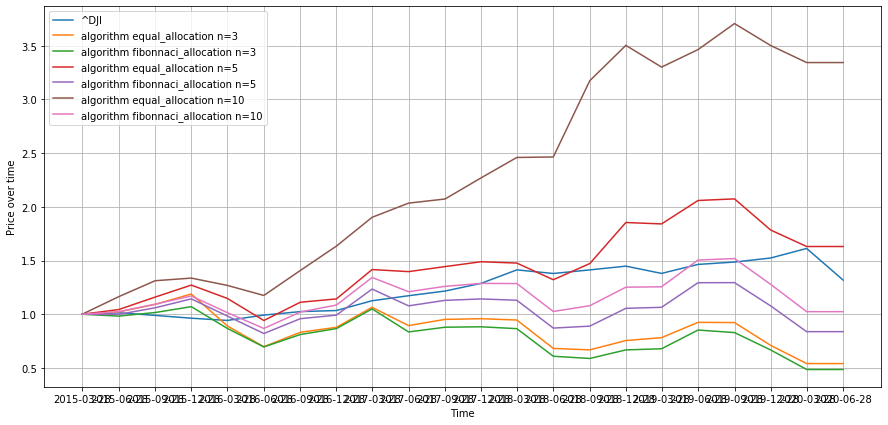

In [1132]:
def _q_index_to_date(q_index: QuarterlyIndex):
    return datetime(q_index[YEAR], q_index[QUARTER]*3, 28).date()

def equal_allocation(n_largest_df: pd.DataFrame, cash: float):
    portfolio = {}
    n = n_largest_df.shape[0]

    # iter over rows, largest is shown first
    for idx, row in n_largest_df.iterrows():
        portfolio[idx] = cash / n
    
    return portfolio

def fibonnaci_allocation(n_largest_df: pd.DataFrame, cash:float):
    portfolio = {}
    n = n_largest_df.shape[0]
    fibonacci_seq = [1,1,2,3,5,8,13,21,34,55][:n]
    fib_sum = sum(fibonacci_seq)
    
    i=n-1
    for idx, row in n_largest_df.iterrows():
        portfolio[idx] = cash * fibonacci_seq[i] / fib_sum
        i -= 1
    
    return portfolio
        

def sell_portfolio(df, portfolio: Dict[QuarterlyIndex, float]):
    total_value = 0
    
    for idx, value in portfolio.items():
        next_quarter_idx = get_next_quarterly_index(idx)
        try:
            change_in_price = df.loc[next_quarter_idx][f'{DELTA_PREFIX}{QuarterlyColumns.PRICE_AVG}']
        except:
            print(f'Failed to find data for {next_quarter_idx}')
            change_in_price = 0
        total_value += value * (1 + change_in_price)
    
    return total_value if total_value > 0 else 0


def _transform_df_for_prediction(df: pd.DataFrame):
    index_transformer = IndexSwitchTransformer(INDEX_COLUMNS)
    index_transformer.fit(df)
    
    data_pipeline_no_outlier_extraction = Pipeline(steps=[
        ('reset_index', index_transformer),
        ('filter_columns', ColumnFilter(FEATURE_COLUMNS + CATEGORICAL_COLUMNS + [TARGET_COLUMN])),
        ('one_hot_encode', categorical_to_dummy),
        ('numeric_scaler', numerical_scaler),
        ('restore_index', index_transformer)
    ])
    
    return data_pipeline_no_outlier_extraction.transform(df)


def compute_performance(df: pd.DataFrame, 
                        data_pipeline: Pipeline, 
                        model, 
                        start_date: date, 
                        n: int, 
                        allocation_fn):
    history = []
    portfolio = {}
    _, prev_q, now_year = _date_to_index((datetime.now() - timedelta(days=90)).date())
    cash = 1.0
    q_index = _date_to_index(start_date)
    
    while (not(q_index[QUARTER] == prev_q and q_index[YEAR] == now_year)):

        if portfolio:
            print(f'Evaluating performance for Q{q_index[QUARTER]} {q_index[YEAR]}. Current value: {cash}')
            cash = sell_portfolio(df, portfolio)

        X_q_year = df.loc(axis=0)[:, q_index[QUARTER], q_index[YEAR]]   
        X_q_year_transformed = _transform_df_for_prediction(X_q_year)
        y_pred = X_q_year_transformed[TARGET_COLUMN].reset_index()  # Using the indexes only
        X_q_year_transformed.drop(columns=[TARGET_COLUMN], inplace=True)
        
        y_pred[TARGET_COLUMN] = model.predict(X_q_year_transformed)
        y_pred = y_pred.set_index(INDEX_COLUMNS)
        
        portfolio = allocation_fn(y_pred.nlargest(n, columns=[TARGET_COLUMN]), cash)
        
        history.append(portfolio)
        q_index = get_next_quarterly_index(q_index)
    
    history.append(portfolio)
    
    return sell_portfolio(df, portfolio), history

start_date = datetime(2015,1,1)

idx_performance = market_index_df.loc(axis=0)['^DJI',:, :]
idx_performance = idx_performance[pd.to_datetime(idx_performance[QuarterlyColumns.DATE]) >= start_date][QuarterlyColumns.PRICE_AVG]
values_dates = [(value, _q_index_to_date(q_index)) for value, q_index in zip(
    idx_performance, idx_performance.index)]
values_dates = sorted(values_dates, key=lambda x: x[1])
# divide by initial value so that it starts at 1.0
idx_performance = [values_dates[i][0]/values_dates[0][0] for i in range(len(values_dates))]
dates = [values_dates[i][1] for i in range(len(values_dates))]

fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.plot(dates, idx_performance, label='^DJI')
ax1.set_ylabel('Price over time')
ax1.set_xlabel('Time')
ax1.set_xticks(dates)

for n in [3,5,10]:
    for allocation_fn in [equal_allocation, fibonnaci_allocation]:
        final_value, history = compute_performance(
            quarterly_df, data_pipeline, reg_model, start_date, n=n, allocation_fn=allocation_fn)

        algorithm_performance = [sum(hist_dict.values()) for hist_dict in history]
        ax1.plot(dates, algorithm_performance, label=f'algorithm {allocation_fn.__name__} n={n}')

ax1.legend()
ax1.grid()
fig.show()



In [1133]:
X_q_year = quarterly_df.loc(axis=0)[:, 1, 2020]   
X_q_year_transformed = _transform_df_for_prediction(X_q_year)
y_pred = X_q_year_transformed[TARGET_COLUMN].reset_index()  # Using the indexes only
X_q_year_transformed.drop(columns=[TARGET_COLUMN], inplace=True)
y_pred[TARGET_COLUMN] = reg.predict(X_q_year_transformed)
y_pred = y_pred.set_index(INDEX_COLUMNS)

y_pred.nlargest(10, columns=[TARGET_COLUMN])

/Users/ezras/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 36 is different from 164)